In [2]:
#1024——glitch生成
import matplotlib.pyplot as pp
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import sigma
from pycbc import types
from pycbc.detector import Detector
from pycbc.filter import matched_filter
import pycbc
from pycbc.psd import welch
import pycbc.noise
import pycbc.psd
from pycbc import waveform
import scipy
import h5py
import os
import random
import numpy as np

from multiprocessing import Pool
from pycbc import distributions

from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries

In [3]:
import numpy as np
from scipy.integrate import quad
#函数定义
def z_to_d_ang(z, H0, Omega_m, Omega_Lambda):#输入红移输出直径距离
    c = 299792.458  # 光速，单位：km/s
    # 定义被积函数
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    # 积分计算
    result, _ = quad(integrand, 0, z)
    # 计算距离
    distance = c / (H0 * (1+z) )* result
    return distance


def zl_zs_to_dsl_ang(zl,zs, H0, Omega_m, Omega_Lambda):#输入红移、输出直径距离
    c = 299792.458  # 光速，单位：km/s
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    result, _ = quad(integrand, zl, zs)
    distance = c / (H0 * (1+zs) )* result
    return distance


def d_ang_to_dl(D_ang,z):#输入角直径距离、输出光度距离
    return D_ang*(1+z)**2


# 点质量透镜模型

In [4]:
import numpy as np

class Point_mass_lens_model:
    def __init__(self):
        pass
    
    def F_f(self, f, M_LZ, epsilon, D_L, xi_0, D_s):
        return np.abs(self.miu_p(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 - \
            1j * np.abs(self.miu_c(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 * \
            np.exp(2j * np.pi * f * self.dt(M_LZ, self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))
    
    def miu_p(self, y, beta):
        return 0.5 + (y**2 + 2) / (2 * y * beta)
    
    def miu_c(self, y, beta):
        return 0.5 - (y**2 + 2) / (2 * y * beta)
    #G:m³/kg·s²
    def dt(self, M_LZ, y, beta):#单位s
        return 4 * M_LZ*(y * beta / 2 + np.log((beta + y) / (beta - y))) * scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    def beta(self, y):
        return (y**2 + 4)**0.5
    
    def y(self, epsilon, D_L, xi_0, D_s):
        return epsilon * D_L / xi_0 / D_s

# y,SIS的μ_+-,Δt,F(f)PM的μ+-,Δt,F(f)

In [ ]:
    # 4.5
def yy_ll(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def miu_p_sis(y_l):
    return 1+1/y_l

def miu_c_sis(y_l):
    return -1+1/y_l
    
def det_t_sis(M_L,y_l,zl):
    return 8*M_L*(1+zl)*y_l* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def miu_p_pm(y_l):
    return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

def miu_c_pm(y_l):
    return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)
    
def det_t_pm(M_L,y_l,zl):
    return 2*M_L*(1+zl)*(y_l*(y_l**2+4)**0.5+2*np.log(((y_l**2+4)**0.5+y_l)/((y_l**2+4)**0.5-y_l)))* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def PM_model(f, miu_p, miu_c, det_t):
    return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)

def SIS_model(f, miu_p, miu_c, det_t,y_l):
    if y_l<1:
        return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)
    else:
        return np.abs(miu_p)**0.5 
    
def y_lens(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def M_L_Z(M_L,z):
    return M_L*(1+z)
    
def x_i_0(M_L,D_LS,D_L,D_S): #G:m³/kg·s² #m^1 kg^-1 Mc^1  Mpc^1 单位转化成MPc,,,,1.989×1030 千克,,,3.0857E+22
    return ((4*scipy.constants.G*M_L/scipy.constants.c**2)*(D_LS*D_L/D_S) /(3.0857e22)*(1.989e30))**0.5

def mc_q_to_m1_m2(mc,q):
    m1=(mc**5*(1+q)/q**3)**(1/5)
    m2=m1*q
    return m1,m2


def get_snr(data,T_obs,fs,psd):
    #波形、1、频率、psd
    N = T_obs*fs
    delta_f = 1.0/T_obs
    delta_t = 1.0/fs

#     win = tukey(N,alpha=1.0/8.0)
    idx = np.argwhere(psd==0.0)
    psd[idx] = 1e300

    xf = np.fft.rfft(data)*delta_t
    #fig = plt.figure()
    #plt.plot(np.real(xf))
    #plt.plot(np.imag(xf))
    SNRsq = 4.0*np.sum((np.abs(xf)**2)/psd)*delta_f
    return np.sqrt(SNRsq)

@np.vectorize
def gw_waveform(f,A,D,m1,m2,t_c,psi_c,z):
    M=m1+m2
    qq=m1*m2/M**2
    Mz=(1+z)*M
    Mc=qq**(3/5)*Mz
    f_cut=1/(6**(3/2)*np.pi*Mz) / scipy.constants.G * scipy.constants.c**3 /(1.989e30)
    def fi(f,t_c,psi_c,qq,Mc):
        return 2*np.pi*f*t_c-psi_c-np.pi/4+3/4*(8*np.pi*Mc*f)**(-5/3)*(1+20/9*(743/336+11/4*qq)*(np.pi*Mz*f)**(2/3)-16*np.pi*(np.pi*Mz*f))
    if f_cut<f:
        return 0
    else:
        return A/D*Mc**(5/6)*f**(-7/6)*np.exp(1j*fi(f,t_c,psi_c,qq,Mc))*1e-19/0.27


In [5]:
def I_to_y_sis(y_l,I):
    return I-miu_c_sis(y_l)/miu_p_sis(y_l)

def I_to_y_pm(y_l,I):
    return I+miu_c_pm(y_l)/miu_p_pm(y_l)

In [6]:
#固定的参数
calculator = Point_mass_lens_model()
T_obs=10
N_fs=4096#采样率为4096Hz
N_s=T_obs*N_fs#对应时域为10s

flen = round(N_s/2)+1
delta_f = 1.0 / T_obs
delta_t=1/N_fs
f_low=30
flow=30

tsamples = int(T_obs / delta_t)

In [7]:
# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdh = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdh.sample_frequencies)  # 生成的 y 值
y_new[psdh.sample_frequencies<f_low]=0
psdh.data=y_new
psdh_snr = psdh.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdl = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdl.sample_frequencies)  # 生成的 y 值
y_new[psdl.sample_frequencies<f_low]=0
psdl.data=y_new
psdl_snr = psdl.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/avirgo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdv = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdv.sample_frequencies)  # 生成的 y 值
y_new[psdv.sample_frequencies<f_low]=0
psdv.data=y_new
psdv_snr = psdv.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/k1_o4_high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdk = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdk.sample_frequencies)  # 生成的 y 值
y_new[psdk.sample_frequencies<f_low]=0
psdk.data=y_new
psdk_snr = psdk.copy()

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler


from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime


# 这个是那一堆点的数据

# PM

<ipython-input-9-062413ee05f4>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)
<ipython-input-9-062413ee05f4>:2: RuntimeWarning: divide by zero encountered in true_divide
  return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)
<ipython-input-9-062413ee05f4>:12: RuntimeWarning: invalid value encountered in true_divide
  I=np.abs(miu_c_pm(y_l)/miu_p_pm(y_l))


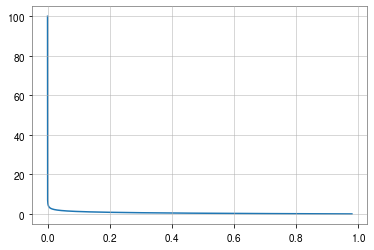

In [9]:
def miu_p_pm(y_l):
    return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

def miu_c_pm(y_l):
    return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)


import numpy as np
import scipy

y_l=np.linspace(0,100,10000)
I=np.abs(miu_c_pm(y_l)/miu_p_pm(y_l))
I[-1]=0

f_I_to_y_PM=scipy.interpolate.interp1d(I,y_l,kind='linear')
xnew=np.linspace(0,1.0,10000)   
ynew=f_I_to_y_PM(xnew)
plt.plot(xnew,ynew)

In [ ]:
def miu_p_pm(y_l):
    return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

def miu_c_pm(y_l):
    return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

#固定的参数
det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')
Z_L=0
for I in np.linspace(0,1,20):
    for dtt in np.linspace(0,0.2,20):
        y_l=f_I_to_y_PM(I)
        miu_pp=miu_p_pm(y_l)
        miu_cc=miu_c_pm(y_l)
        I_tt=np.abs(miu_cc)/np.abs(miu_pp)
        for SNRRR in [8,12]:
            hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
            result = types.FrequencySeries(PM_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt),delta_f=N_fs/N_s)
            def get_wave_plus_gaosnoise_t_gen(saaaa):
                while True:
                    tc=random.uniform(7,8)
                    mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
                    q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
                    mc_samples = mc_distribution.rvs(size=1)
                    q_samples = q_distribution.rvs(size=1)
                    mc=mc_samples[0][0]
                    q=q_samples[0][0]
                    m1,m2=mc_q_to_m1_m2(mc,q)

                    zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
                    zs_samples=zs_distribution.rvs(size=1)
                    Z_s=zs_samples[0][0]
                    D_S=z_to_d_ang(Z_s,70,0.3,0.7)
                    
                    distance=d_ang_to_dl(D_S,Z_s)

                    sky_distribution = distributions.sky_location.UniformSky()
                    sky_samples=sky_distribution.rvs(size=1)
                    dec = sky_samples[0][0]#纬度
                    ra = sky_samples[0][1]#经度

                    psi = random.uniform(0,np.pi*2)#偏振角ψ
                    inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
                    coa_phase=random.uniform(0,np.pi*2)#合并相位
                    #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM


##try 后与PM无本质区别, 除了保存的文件名不同.
                    try:
                        hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                                 mass1=m1*(1+Z_s),#红移质量1
                                                 mass2=m2*(1+Z_s),#红移质量2
                                                 distance=distance,#距离，MPC
                                                 coa_phase=coa_phase,#合并相位
                                                 inclination=inc,#轨道和视线的夹角
                                                 spin1x=0,
                                                 spin1y=0,
                                                 spin1z=0,#自旋1
                                                 spin2x=0,
                                                 spin2y=0,
                                                 spin2z=0,#自旋2
                                                 eccentricity=0,#轨道偏心率
                                                 lambda1=0,#潮汐相，中子星有
                                                 lambda2=0,
                                                 delta_t=1.0/N_fs,
                                                 f_lower=30)
                    except:
                        continue

                    fp_1, fc_1 = det_1.antenna_pattern(
                                    right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                    fp_2, fc_2 = det_2.antenna_pattern(
                                    right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                    fp_3, fc_3 = det_3.antenna_pattern(
                                    right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                    fp_4, fc_4 = det_4.antenna_pattern(
                                    right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

                    ht_1 = fp_1*hp + fc_1*hc
                    ht_2 = fp_2*hp + fc_2*hc
                    ht_3 = fp_3*hp + fc_3*hc
                    ht_4 = fp_4*hp + fc_4*hc


                    ht_1.resize(N_s)
                    ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
                    ht_1.start_time=0
                    ht_2.resize(N_s)
                    ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
                    ht_2.start_time=0
                    ht_3.resize(N_s)
                    ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
                    ht_3.start_time=0
                    ht_4.resize(N_s)
                    ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
                    ht_4.start_time=0

                    hp_f_1=ht_1.to_frequencyseries()
                    hp_flens_1=hp_f_1*result
                    hp_t_lens_1=hp_flens_1.to_timeseries()
                    #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                    hp_f_2=ht_2.to_frequencyseries()
                    hp_flens_2=hp_f_2*result
                    hp_t_lens_2=hp_flens_2.to_timeseries()
                    #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                    hp_f_3=ht_3.to_frequencyseries()
                    hp_flens_3=hp_f_3*result
                    hp_t_lens_3=hp_flens_3.to_timeseries()
                    #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                    hp_f_4=ht_4.to_frequencyseries()
                    hp_flens_4=hp_f_4*result
                    hp_t_lens_4=hp_flens_4.to_timeseries()


                    #利用高斯 psd生成噪声：
                    #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
                    noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
                    hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
                    hp_t_lens_plusnoise_1.data+=noise_et1.data

                    noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
                    hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
                    hp_t_lens_plusnoise_2.data+=noise_et2.data

                    noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
                    hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
                    hp_t_lens_plusnoise_3.data+=noise_et3.data

                    noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
                    hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
                    hp_t_lens_plusnoise_4.data+=noise_et4.data

                    snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
                    snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
                    snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
                    snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
                    snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
                    #print(snr)

                    #print(snr,D_S,D_LS,D_L,distance)
                    if snr<(SNRRR-2) or snr>(SNRRR+2):
                        continue

                    L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
                    H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
                    V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
                    K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

                    canshu=[dtt,I_tt]#12个

                    return [L11data.data,H11data.data,V11data.data,K11data.data],[1.0],[snr,m1+m2],canshu

            def get_wave_plus_gaosnoise_t_gen_cai(data):
                nnnyyu=2**5
                samples_all=torch.zeros((data.shape[0],2,nnnyyu))
                for i in range(data.shape[0]):
                    estimator.eval()
                    with torch.no_grad():
                        samples = estimator.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
                        samples = postprocess(samples)

                    samples_all[i,0,:]=samples[:,0,0]
                    samples_all[i,1,:]=samples[:,0,1]
                return samples_all


            pool = Pool(processes=56)
            results = pool.map(get_wave_plus_gaosnoise_t_gen, [0.5]*100)
            all_x_vail_data = torch.tensor(np.concatenate([x for x,y,z,u in results]).reshape(100,4,40960),dtype=torch.float32)
            #all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail_data).reshape(100,2,2**5)
            all_y_vail = torch.tensor(np.concatenate([y for x,y,z,u in results]).reshape(100,1),dtype=torch.float32)#标签-1
            all_z_vail = torch.tensor(np.concatenate([z for x,y,z,u in results]).reshape(100,2),dtype=torch.float32)#参数
            all_u_vail = torch.tensor(np.concatenate([u for x,y,z,u in results]).reshape(100,2),dtype=torch.float32)#参数

            pool.close()
            pool.join()
            
            np.save(f'./data/I_dt/test_PM_data_{I}_{dtt}_{SNRRR}.npy',all_x_vail_data)
            #np.save(f'./data/I_dt/test_PM_data__{I}_{y_l}_{SNRRR}.npy',all_x_vail)
            np.save(f'./data/I_dt/test_PM_label_{I}_{dtt}_{SNRRR}.npy',all_y_vail)
            np.save(f'./data/I_dt/test_PM_err_{I}_{dtt}_{SNRRR}.npy',all_z_vail)    
            np.save(f'./data/I_dt/test_PM_canshu_{I}_{dtt}_{SNRRR}.npy',all_u_vail)



: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNING


: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNING
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNINGWARNING
WARNINGWARNING
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]



: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNING
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNING

# SIS

In [ ]:
def I_to_y_SIS(I):
    y1=(1+I)/(1-I)
    y2=(1-I)/(1+I)
    return y1,y2


In [ ]:
Z_L=0
xx=[]
yy=[]
asas=0
for I in np.linspace(0,1,20):
    #for y_l in np.linspace(1e-5,100,1000):
    for dtt in np.linspace(0,0.2,20):
        yy_all=I_to_y_SIS(I)
        for y_l in yy_all:
            miu_pp=miu_p_sis(y_l)
            miu_cc=miu_c_sis(y_l)
            I_tt=np.abs(miu_cc)/np.abs(miu_pp)
            asas+=1
            xx.append(I_tt)
            yy.append(dtt)
            hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
            if y_l<1:
                result = types.FrequencySeries(SIS_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt,y_l),delta_f=N_fs/N_s)
            else:
                result = types.FrequencySeries([SIS_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt,12)]*(round(N_s/2)+1),delta_f=N_fs/N_s)

In [ ]:
#固定的参数
Z_L=0

det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')
for SNRRR in [8,12,16]:
    for I in np.linspace(0,1,20):
        #for y_l in np.linspace(1e-5,100,1000):
        for dtt in np.linspace(0,0.2,20):
            yy_all=I_to_y_SIS(I)
            for y_l in yy_all:
                miu_pp=miu_p_sis(y_l)
                miu_cc=miu_c_sis(y_l)
                asas+=1
                xx.append(I_tt)
                yy.append(dtt)
                hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
                if y_l<1:
                    result = types.FrequencySeries(SIS_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt,y_l),delta_f=N_fs/N_s)
                    images=2
                else:
                    result = types.FrequencySeries([SIS_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt,12)]*(round(N_s/2)+1),delta_f=N_fs/N_s)
                    images=1
# 以下PM与SIS完全相同

                def get_wave_plus_gaosnoise_t_gen_sis(saaaa):
                    hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
                    while True:
                        tc=random.uniform(7,8)
                        mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
                        q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
                        mc_samples = mc_distribution.rvs(size=1)
                        q_samples = q_distribution.rvs(size=1)
                        mc=mc_samples[0][0]
                        q=q_samples[0][0]
                        m1,m2=mc_q_to_m1_m2(mc,q)


                        zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
                        zs_samples=zs_distribution.rvs(size=1)
                        Z_s=zs_samples[0][0]
                        D_S=z_to_d_ang(Z_s,70,0.3,0.7)

                        distance=d_ang_to_dl(D_S,Z_s)

                        sky_distribution = distributions.sky_location.UniformSky()
                        sky_samples=sky_distribution.rvs(size=1)
                        dec = sky_samples[0][0]#纬度
                        ra = sky_samples[0][1]#经度

                        psi = random.uniform(0,np.pi*2)#偏振角ψ
                        inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
                        coa_phase=random.uniform(0,np.pi*2)#合并相位
                        #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM
##try 后与PM无本质区别, 除了保存的文件名不同.
                        try:
                            hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                                     mass1=m1*(1+Z_s),#红移质量1
                                                     mass2=m2*(1+Z_s),#红移质量2
                                                     distance=distance,#距离，MPC
                                                     coa_phase=coa_phase,#合并相位
                                                     inclination=inc,#轨道和视线的夹角
                                                     spin1x=0,
                                                     spin1y=0,
                                                     spin1z=0,#自旋1
                                                     spin2x=0,
                                                     spin2y=0,
                                                     spin2z=0,#自旋2
                                                     eccentricity=0,#轨道偏心率
                                                     lambda1=0,#潮汐相，中子星有
                                                     lambda2=0,
                                                     delta_t=1.0/N_fs,
                                                     f_lower=30)
                        except:
                            continue

                        fp_1, fc_1 = det_1.antenna_pattern(
                                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                        fp_2, fc_2 = det_2.antenna_pattern(
                                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                        fp_3, fc_3 = det_3.antenna_pattern(
                                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
                        fp_4, fc_4 = det_4.antenna_pattern(
                                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

                        ht_1 = fp_1*hp + fc_1*hc
                        ht_2 = fp_2*hp + fc_2*hc
                        ht_3 = fp_3*hp + fc_3*hc
                        ht_4 = fp_4*hp + fc_4*hc


                        ht_1.resize(N_s)
                        ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
                        ht_1.start_time=0
                        ht_2.resize(N_s)
                        ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
                        ht_2.start_time=0
                        ht_3.resize(N_s)
                        ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
                        ht_3.start_time=0
                        ht_4.resize(N_s)
                        ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
                        ht_4.start_time=0

                        hp_f_1=ht_1.to_frequencyseries()
                        hp_flens_1=hp_f_1*result
                        hp_t_lens_1=hp_flens_1.to_timeseries()
                        #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                        hp_f_2=ht_2.to_frequencyseries()
                        hp_flens_2=hp_f_2*result
                        hp_t_lens_2=hp_flens_2.to_timeseries()
                        #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                        hp_f_3=ht_3.to_frequencyseries()
                        hp_flens_3=hp_f_3*result
                        hp_t_lens_3=hp_flens_3.to_timeseries()
                        #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
                        hp_f_4=ht_4.to_frequencyseries()
                        hp_flens_4=hp_f_4*result
                        hp_t_lens_4=hp_flens_4.to_timeseries()


                        #利用高斯 psd生成噪声：
                        noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
                        #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
                        hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
                        hp_t_lens_plusnoise_1.data+=noise_et1.data

                        noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
                        hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
                        hp_t_lens_plusnoise_2.data+=noise_et2.data

                        noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
                        hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
                        hp_t_lens_plusnoise_3.data+=noise_et3.data

                        noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
                        hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
                        hp_t_lens_plusnoise_4.data+=noise_et4.data

                        snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
                        snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
                        snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
                        snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
                        snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
                        #print(snr)

                        #print(snr,D_S,D_LS,D_L,distance)
                        if snr<(SNRRR-2) or snr>(SNRRR+2):
                            continue

                        L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
                        H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
                        V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
                        K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

                        canshu=[dtt,I_tt]#12个

                        return [L11data.data,H11data.data,V11data.data,K11data.data],[1.0],[snr,m1+m2],canshu


                def get_wave_plus_gaosnoise_t_gen_cai_sis(data):
                    nnnyyu=2**5
                    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
                    for i in range(data.shape[0]):
                        estimator.eval()
                        with torch.no_grad():
                            samples = estimator.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
                            samples = postprocess(samples)

                        samples_all[i,0,:]=samples[:,0,0]
                        samples_all[i,1,:]=samples[:,0,1]
                    return samples_all


                pool = Pool(processes=56)
                results = pool.map(get_wave_plus_gaosnoise_t_gen_sis, [0.5]*100)
                all_x_vail_data = torch.tensor(np.concatenate([x for x,y,z,u in results]).reshape(100,4,40960),dtype=torch.float32)
                #all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_sis(all_x_vail_data).reshape(100,2,2**5)
                all_y_vail = torch.tensor(np.concatenate([y for x,y,z,u in results]).reshape(100,1),dtype=torch.float32)
                all_z_vail = torch.tensor(np.concatenate([z for x,y,z,u in results]).reshape(100,2),dtype=torch.float32)
                all_u_vail = torch.tensor(np.concatenate([u for x,y,z,u in results]).reshape(100,2),dtype=torch.float32)
                pool.close()
                pool.join()

                np.save(f'./data/I_dt/new/test_SIS_{images}_data_{I}_{dtt}_{SNRRR}.npy',all_x_vail_data)
                np.save(f'./data/I_dt/new/test_SIS_{images}_label_{I}_{dtt}_{SNRRR}.npy',all_y_vail)
                np.save(f'./data/I_dt/new/test_SIS_{images}_err_{I}_{dtt}_{SNRRR}.npy',all_z_vail)
                np.save(f'./data/I_dt/new/test_SIS_{images}_canshu_{I}_{dtt}_{SNRRR}.npy',all_u_vail)

                #np.save(f'./data/I_dt/tes_SISt_data_roc_sis_{M_L}_{y_l}_{SNRRR}.npy',all_x_vail)
                
                
                #np.save(f'./data/I_dt/test_PM_data_{I}_{dtt}_{SNRRR}.npy',all_x_vail_data)
                ##np.save(f'./data/I_dt/test_PM_data__{I}_{y_l}_{SNRRR}.npy',all_x_vail)
                #np.save(f'./data/I_dt/test_PM_label_{I}_{dtt}_{SNRRR}.npy',all_y_vail)
                #np.save(f'./data/I_dt/test_PM_err_{I}_{dtt}_{SNRRR}.npy',all_z_vail)

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

# 参数精度数据集生成

In [19]:

#1024——glitch生成
import matplotlib.pyplot as pp
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import sigma
from pycbc import types
from pycbc.detector import Detector
from pycbc.filter import matched_filter
import pycbc
from pycbc.psd import welch
import pycbc.noise
import pycbc.psd
from pycbc import waveform
import scipy
import h5py
import os
import random
import numpy as np

from multiprocessing import Pool
from pycbc import distributions

from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries




data_psd='./'



import numpy as np
from scipy.integrate import quad
#函数定义
def z_to_d_ang(z, H0, Omega_m, Omega_Lambda):#输入红移输出直径距离
    c = 299792.458  # 光速，单位：km/s
    # 定义被积函数
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    # 积分计算
    result, _ = quad(integrand, 0, z)
    # 计算距离
    distance = c / (H0 * (1+z) )* result
    return distance


def zl_zs_to_dsl_ang(zl,zs, H0, Omega_m, Omega_Lambda):#输入红移、输出直径距离
    c = 299792.458  # 光速，单位：km/s
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    result, _ = quad(integrand, zl, zs)
    distance = c / (H0 * (1+zs) )* result
    return distance


def d_ang_to_dl(D_ang,z):#输入角直径距离、输出光度距离
    return D_ang*(1+z)**2





#点质量透镜模型
class Point_mass_lens_model:
    def __init__(self):
        pass
    
    def F_f(self, f, M_LZ, epsilon, D_L, xi_0, D_s):
        return np.abs(self.miu_p(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 - \
            1j * np.abs(self.miu_c(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 * \
            np.exp(2j * np.pi * f * self.dt(M_LZ, self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))
    
    def miu_p(self, y, beta):
        return 0.5 + (y**2 + 2) / (2 * y * beta)
    
    def miu_c(self, y, beta):
        return 0.5 - (y**2 + 2) / (2 * y * beta)
    #G:m³/kg·s²
    def dt(self, M_LZ, y, beta):#单位s
        return 4 * M_LZ*(y * beta / 2 + np.log((beta + y) / (beta - y))) * scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    def beta(self, y):
        return (y**2 + 4)**0.5
    
    def y(self, epsilon, D_L, xi_0, D_s):
        return epsilon * D_L / xi_0 / D_s


    
    
def yy_ll(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def miu_p_sis(y_l):
    return 1+1/y_l

def miu_c_sis(y_l):
    return -1+1/y_l
    
def det_t_sis(M_L,y_l,zl):
    return 8*M_L*(1+zl)*y_l* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def miu_p_pm(y_l):
    return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

def miu_c_pm(y_l):
    return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)
    
def det_t_pm(M_L,y_l,zl):
    return 2*M_L*(1+zl)*(y_l*(y_l**2+4)**0.5+2*np.log(((y_l**2+4)**0.5+y_l)/((y_l**2+4)**0.5-y_l)))* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def PM_model(f, miu_p, miu_c, det_t):
    return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)

def SIS_model(f, miu_p, miu_c, det_t,y_l):
    if y_l<1:
        return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)
    else:
        return np.abs(miu_p)**0.5 
    
def y_lens(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def M_L_Z(M_L,z):
    return M_L*(1+z)
    
def x_i_0(M_L,D_LS,D_L,D_S): #G:m³/kg·s² #m^1 kg^-1 Mc^1  Mpc^1 单位转化成MPc,,,,1.989×1030 千克,,,3.0857E+22
    return ((4*scipy.constants.G*M_L/scipy.constants.c**2)*(D_LS*D_L/D_S) /(3.0857e22)*(1.989e30))**0.5

def mc_q_to_m1_m2(mc,q):
    m1=(mc**5*(1+q)/q**3)**(1/5)
    m2=m1*q
    return m1,m2


def get_snr(data,T_obs,fs,psd):
    #波形、1、频率、psd
    N = T_obs*fs
    delta_f = 1.0/T_obs
    delta_t = 1.0/fs

#     win = tukey(N,alpha=1.0/8.0)
    idx = np.argwhere(psd==0.0)
    psd[idx] = 1e300    

    xf = np.fft.rfft(data)*delta_t
    #fig = plt.figure()
    #plt.plot(np.real(xf))
    #plt.plot(np.imag(xf))
    SNRsq = 4.0*np.sum((np.abs(xf)**2)/psd)*delta_f
    return np.sqrt(SNRsq)

@np.vectorize
def gw_waveform(f,A,D,m1,m2,t_c,psi_c,z):
    M=m1+m2
    qq=m1*m2/M**2
    Mz=(1+z)*M
    Mc=qq**(3/5)*Mz
    f_cut=1/(6**(3/2)*np.pi*Mz) / scipy.constants.G * scipy.constants.c**3 /(1.989e30)
    def fi(f,t_c,psi_c,qq,Mc):
        return 2*np.pi*f*t_c-psi_c-np.pi/4+3/4*(8*np.pi*Mc*f)**(-5/3)*(1+20/9*(743/336+11/4*qq)*(np.pi*Mz*f)**(2/3)-16*np.pi*(np.pi*Mz*f))
    if f_cut<f:
        return 0
    else:
        return A/D*Mc**(5/6)*f**(-7/6)*np.exp(1j*fi(f,t_c,psi_c,qq,Mc))*1e-19/0.27


#固定的参数
calculator = Point_mass_lens_model()
T_obs=10
N_fs=4096#采样率为4096Hz
N_s=T_obs*N_fs#对应时域为10s

flen = round(N_s/2)+1
delta_f = 1.0 / T_obs
delta_t=1/N_fs
f_low=30
flow=30

tsamples = int(T_obs / delta_t)

# 打开txt文件以读取内容
with open(data_psd+'/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdh = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdh.sample_frequencies)  # 生成的 y 值
y_new[psdh.sample_frequencies<f_low]=0
psdh.data=y_new
psdh_snr = psdh.copy()

# 打开txt文件以读取内容
with open(data_psd+'/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdl = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdl.sample_frequencies)  # 生成的 y 值
y_new[psdl.sample_frequencies<f_low]=0
psdl.data=y_new
psdl_snr = psdl.copy()

# 打开txt文件以读取内容
with open(data_psd+'/avirgo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdv = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdv.sample_frequencies)  # 生成的 y 值
y_new[psdv.sample_frequencies<f_low]=0
psdv.data=y_new
psdv_snr = psdv.copy()

# 打开txt文件以读取内容
with open(data_psd+'/k1_o4_high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdk = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdk.sample_frequencies)  # 生成的 y 值
y_new[psdk.sample_frequencies<f_low]=0
psdk.data=y_new
psdk_snr = psdk.copy()


#! 后面开始与前面不同

#固定的参数
calculator = Point_mass_lens_model()
det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')






import h5py


for SSRRNN in [8,16,24,32]:
    def get_wave_plus_gaosnoise_t_gen(saaaa):
        hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
        while True:
            epsilon=random.uniform(1e-6,0.5)*1e-6#MPc

            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(10,6000))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_L=dl_samples[0][0]
            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(D_L,6000+D_L))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_LS=dl_samples[0][0]-D_L#MPc

            M_L=random.uniform(1e3,1e5)#M


            zl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(0,1.0))#MPc
            zl_samples=zl_distribution.rvs(size=1)
            Z_L=zl_samples[0][0]

            zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
            zs_samples=zs_distribution.rvs(size=1)
            Z_s=zs_samples[0][0]

            D_S=z_to_d_ang(Z_s,70,0.3,0.7)
            D_LS=zl_zs_to_dsl_ang(Z_L,Z_s,70,0.3,0.7)
            D_L=z_to_d_ang(Z_L,70,0.3,0.7)

            #z_to_DL
            M_LZ=M_L_Z(M_L,Z_L)#M
            xi_0=x_i_0(M_L,D_LS,D_L,D_S)
            y_l=yy_ll(epsilon, D_L, xi_0, D_S)

            #print(calculator.dt(M_LZ, calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_p(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_c(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))

            dtt=det_t_pm(M_L,y_l,Z_L)
            miu_pp=miu_p_pm(y_l)
            miu_cc=miu_c_pm(y_l)

            I_tt=np.abs(miu_cc)/np.abs(miu_pp)
            #if dtt<2.25e-3 or dtt>3.52 or miu_pp<1.7 or miu_pp>10.51 or miu_cc<-9.51 or miu_cc>-0.17:
            #    continue
            if dtt>0.2 or I_tt<0 or I_tt>1:
                continue
            #print(dtt)
            #print(dtt,miu_pp,miu_cc)
            result = types.FrequencySeries(PM_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt),delta_f=N_fs/N_s)



            tc=random.uniform(7,8)
            mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
            q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
            mc_samples = mc_distribution.rvs(size=1)
            q_samples = q_distribution.rvs(size=1)
            mc=mc_samples[0][0]
            q=q_samples[0][0]
            m1,m2=mc_q_to_m1_m2(mc,q)

            distance=d_ang_to_dl(D_S,Z_s)

            sky_distribution = distributions.sky_location.UniformSky()
            sky_samples=sky_distribution.rvs(size=1)
            dec = sky_samples[0][0]#纬度
            ra = sky_samples[0][1]#经度

            psi = random.uniform(0,np.pi*2)#偏振角ψ
            inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
            coa_phase=random.uniform(0,np.pi*2)#合并相位
            #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM



            try:
                hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                         mass1=m1*(1+Z_s),#红移质量1
                                         mass2=m2*(1+Z_s),#红移质量2
                                         distance=distance,#距离，MPC
                                         coa_phase=coa_phase,#合并相位
                                         inclination=inc,#轨道和视线的夹角
                                         spin1x=0,
                                         spin1y=0,
                                         spin1z=0,#自旋1
                                         spin2x=0,
                                         spin2y=0,
                                         spin2z=0,#自旋2
                                         eccentricity=0,#轨道偏心率
                                         lambda1=0,#潮汐相，中子星有
                                         lambda2=0,
                                         delta_t=1.0/N_fs,
                                         f_lower=30)
            except:
                continue

            fp_1, fc_1 = det_1.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_2, fc_2 = det_2.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_3, fc_3 = det_3.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_4, fc_4 = det_4.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

            ht_1 = fp_1*hp + fc_1*hc
            ht_2 = fp_2*hp + fc_2*hc
            ht_3 = fp_3*hp + fc_3*hc
            ht_4 = fp_4*hp + fc_4*hc


            ht_1.resize(N_s)
            ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
            ht_1.start_time=0
            ht_2.resize(N_s)
            ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
            ht_2.start_time=0
            ht_3.resize(N_s)
            ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
            ht_3.start_time=0
            ht_4.resize(N_s)
            ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
            ht_4.start_time=0

            hp_f_1=ht_1.to_frequencyseries()
            hp_flens_1=hp_f_1*result
            hp_t_lens_1=hp_flens_1.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_2=ht_2.to_frequencyseries()
            hp_flens_2=hp_f_2*result
            hp_t_lens_2=hp_flens_2.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_3=ht_3.to_frequencyseries()
            hp_flens_3=hp_f_3*result
            hp_t_lens_3=hp_flens_3.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_4=ht_4.to_frequencyseries()
            hp_flens_4=hp_f_4*result
            hp_t_lens_4=hp_flens_4.to_timeseries()


            #利用高斯 psd生成噪声：
            noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
            #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
            hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
            hp_t_lens_plusnoise_1.data+=noise_et1.data

            noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
            hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
            hp_t_lens_plusnoise_2.data+=noise_et2.data

            noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
            hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
            hp_t_lens_plusnoise_3.data+=noise_et3.data

            noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
            hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
            hp_t_lens_plusnoise_4.data+=noise_et4.data

            snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
            snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
            snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
            snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
            snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
            #print(snr)
            #print(snr,SSRRNN)
            #print(snr,D_S,D_LS,D_L,distance)
            if snr<(SSRRNN-2) or snr>(SSRRNN+2):
                continue


            L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
            H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
            V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
            K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

            canshu=[dtt,I_tt]#12个

            return [[L11data.data,H11data.data,V11data.data,K11data.data]],[canshu]
    
    num=200#总数
    pool = Pool(processes=56)
    results = pool.map(get_wave_plus_gaosnoise_t_gen, [0.5]*num)
    all_x = np.concatenate([x for x,y in results])
    all_y = np.concatenate([y for x,y in results])
    pool.close()
    pool.join()

    filename = f'./data/PM_theta_{SSRRNN}.h5'
    h5f = h5py.File(filename, 'w')
    h5f.create_dataset('theta',dtype=np.float32, data=all_y)
    h5f.create_dataset('x',dtype=np.float32,data=all_x)
    h5f.close()

# 这之后的好像没用到

In [11]:
def get_wave_plus_gaosnoise_t_nolens(saaaa):
    hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
    while True:
        tc=random.uniform(7,8)
        mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
        q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
        mc_samples = mc_distribution.rvs(size=1)
        q_samples = q_distribution.rvs(size=1)
        mc=mc_samples[0][0]
        q=q_samples[0][0]
        m1,m2=mc_q_to_m1_m2(mc,q)

        
        zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
        zs_samples=zs_distribution.rvs(size=1)
        Z_s=zs_samples[0][0]
        D_S=z_to_d_ang(Z_s,70,0.3,0.7)
        
        distance=d_ang_to_dl(D_S,Z_s)

        sky_distribution = distributions.sky_location.UniformSky()
        sky_samples=sky_distribution.rvs(size=1)
        dec = sky_samples[0][0]#纬度
        ra = sky_samples[0][1]#经度

        psi = random.uniform(0,np.pi*2)#偏振角ψ
        inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
        coa_phase=random.uniform(0,np.pi*2)#合并相位
        #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM

        try:
            hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                     mass1=m1*(1+Z_s),#红移质量1
                                     mass2=m2*(1+Z_s),#红移质量2
                                     distance=distance,#距离，MPC
                                     coa_phase=coa_phase,#合并相位
                                     inclination=inc,#轨道和视线的夹角
                                     spin1x=0,
                                     spin1y=0,
                                     spin1z=0,#自旋1
                                     spin2x=0,
                                     spin2y=0,
                                     spin2z=0,#自旋2
                                     eccentricity=0,#轨道偏心率
                                     lambda1=0,#潮汐相，中子星有
                                     lambda2=0,
                                     delta_t=1.0/N_fs,
                                     f_lower=30)
        except:
            continue

        fp_1, fc_1 = det_1.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        fp_2, fc_2 = det_2.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        fp_3, fc_3 = det_3.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        fp_4, fc_4 = det_4.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

        ht_1 = fp_1*hp + fc_1*hc
        ht_2 = fp_2*hp + fc_2*hc
        ht_3 = fp_3*hp + fc_3*hc
        ht_4 = fp_4*hp + fc_4*hc


        ht_1.resize(N_s)
        ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
        ht_1.start_time=0
        ht_2.resize(N_s)
        ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
        ht_2.start_time=0
        ht_3.resize(N_s)
        ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
        ht_3.start_time=0
        ht_4.resize(N_s)
        ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
        ht_4.start_time=0

        #无透镜的
        hp_t_lens_1=ht_1.copy()
        hp_t_lens_2=ht_2.copy()
        hp_t_lens_3=ht_3.copy()
        hp_t_lens_4=ht_4.copy()


        #利用高斯 psd生成噪声：
        noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
        #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
        hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
        hp_t_lens_plusnoise_1.data+=noise_et1.data

        noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
        hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
        hp_t_lens_plusnoise_2.data+=noise_et2.data

        noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
        hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
        hp_t_lens_plusnoise_3.data+=noise_et3.data

        noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
        hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
        hp_t_lens_plusnoise_4.data+=noise_et4.data

        snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
        snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
        snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
        snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
        snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
        #print(snr)

        #print(snr,D_S,D_LS,D_L,distance)
        if snr<(SNRRR-2) or snr>(SNRRR+2):
            continue

        L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
        H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
        V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
        K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

        return [L11data.data,H11data.data,V11data.data,K11data.data],[0.0]

In [ ]:
#固定的参数
Z_L=0

det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')


for SNRRR in [16,24,32]:
    for iii in range(4):
        pool = Pool(processes=56)
        results = pool.map(get_wave_plus_gaosnoise_t_nolens, [0.5]*10000)
        all_x_vail_data = torch.tensor(np.concatenate([x for x,y in results]).reshape(10000,4,40960),dtype=torch.float32)
        #all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_sis(all_x_vail_data).reshape(100,2,2**5)
        all_y_vail = torch.tensor(np.concatenate([y for x,y in results]).reshape(10000,1),dtype=torch.float32)
        pool.close()
        pool.join()

        np.save(f'./data/I_dt/test_nolens_data_{SNRRR}_{iii}.npy',all_x_vail_data)
        #np.save(f'./data/I_dt/tes_SISt_data_roc_sis_{M_L}_{y_l}_{SNRRR}.npy',all_x_vail)
        np.save(f'./data/I_dt/test_nolens_label_{SNRRR}_{iii}.npy',all_y_vail)


        #np.save(f'./data/I_dt/test_PM_data_{I}_{dtt}_{SNRRR}.npy',all_x_vail_data)
        ##np.save(f'./data/I_dt/test_PM_data__{I}_{y_l}_{SNRRR}.npy',all_x_vail)
        #np.save(f'./data/I_dt/test_PM_label_{I}_{dtt}_{SNRRR}.npy',all_y_vail)
        #np.save(f'./data/I_dt/test_PM_err_{I}_{dtt}_{SNRRR}.npy',all_z_vail)

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNING: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNING




WARNINGWARNING
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNING
WARNINGWARNINGWARNINGWARNINGWARNINGWARNING
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

WARNING




: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNINGWARNINGWARNING

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNING: IERSStaleWarning: leap-second file is expired. [a

In [ ]:
$$$$$$$$$$$$$$$$$$$$$$$￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥￥

#固定的参数
Z_L=0

det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')


for SNRRR in [8]:
    for iii in range(4):
        pool = Pool(processes=56)
        results = pool.map(get_wave_plus_gaosnoise_t_nolens, [0.5]*10000)
        all_x_vail_data = torch.tensor(np.concatenate([x for x,y in results]).reshape(10000,4,40960),dtype=torch.float32)
        #all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_sis(all_x_vail_data).reshape(100,2,2**5)
        all_y_vail = torch.tensor(np.concatenate([y for x,y in results]).reshape(10000,1),dtype=torch.float32)
        pool.close()
        pool.join()

        np.save(f'./data/I_dt/test_nolens_data_{SNRRR}_{iii}.npy',all_x_vail_data)
        #np.save(f'./data/I_dt/tes_SISt_data_roc_sis_{M_L}_{y_l}_{SNRRR}.npy',all_x_vail)
        np.save(f'./data/I_dt/test_nolens_label_{SNRRR}_{iii}.npy',all_y_vail)


        #np.save(f'./data/I_dt/test_PM_data_{I}_{dtt}_{SNRRR}.npy',all_x_vail_data)
        ##np.save(f'./data/I_dt/test_PM_data__{I}_{y_l}_{SNRRR}.npy',all_x_vail)
        #np.save(f'./data/I_dt/test_PM_label_{I}_{dtt}_{SNRRR}.npy',all_y_vail)
        #np.save(f'./data/I_dt/test_PM_err_{I}_{dtt}_{SNRRR}.npy',all_z_vail)